In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#Own Model

#Need to Train ResNet50

#Need to Train Vgg16 on this data!

Preprocessing and knowing the data

In [ ]:
df = pd.read_csv("../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv")

In [ ]:
df.head(2)

df.info()

In [ ]:
df.info()

In [ ]:
k = np.array(list(map(int,df.iloc[0,1].split(" "))),dtype='uint8').reshape((48,48))

In [ ]:
plt.imshow(k,cmap='gray')

In [ ]:
df[['emotion']]

In [ ]:
df[['Usage']].value_counts()

In [ ]:
df[df['Usage']=='Training']['emotion'].value_counts()

In [ ]:
df_train = df[df['Usage']=='Training']

In [ ]:
df_train['emotion'].value_counts()

**Since there is class imbalance let's try to take 436 images of each emotion and try!

In [ ]:
emotion_0 = df_train[df_train['emotion']==0][:436]
emotion_1 = df_train[df_train['emotion']==1][:436]
emotion_2 = df_train[df_train['emotion']==2][:436]
emotion_3 = df_train[df_train['emotion']==3][:436]
emotion_4 = df_train[df_train['emotion']==4][:436]
emotion_5 = df_train[df_train['emotion']==5][:436]
emotion_6 = df_train[df_train['emotion']==6][:436]

In [ ]:
balanced_df_train = pd.concat([emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6])

In [ ]:
balanced_df_train['emotion'].value_counts()

In [ ]:
df_train

In [ ]:
df_test = df[df['Usage']=='PublicTest']

In [ ]:
df_test

In [ ]:
df[df['Usage']=='PrivateTest']

In [ ]:
X_train,y_train = [],[]
X_valid,y_valid = [],[]
X_test,y_test = [],[]

for index,row in df.iterrows():
    val = list(map(int,row['pixels'].split(" ")))
    req = [0,0,0,0,0,0,0]
    if row['Usage']=='Training':
        
        X_train.append(np.array(val,dtype='uint8').reshape(48,48,1))
        req[row['emotion']]=1
        y_train.append(np.array(req))
    elif row['Usage']=='PublicTest':
        X_valid.append(np.array(val,dtype='uint8').reshape(48,48,1))
        req[row['emotion']]=1
        y_valid.append(np.array(req))
    elif row['Usage']=='PrivateTest':
        X_test.append(np.array(val,dtype='uint8').reshape(48,48,1))
        req[row['emotion']]=1
        y_test.append(np.array(req))
    else:
        print("Error Occuredd!")

In [ ]:
X_b_train,y_b_train = [],[]
for index,row in balanced_df_train.iterrows():
    val = list(map(int,row['pixels'].split(" ")))
    req = [0,0,0,0,0,0,0]
    X_b_train.append(np.array(val,dtype='uint8').reshape(48,48,1))
    req[row['emotion']]=1
    y_b_train.append(np.array(req))

In [ ]:
X_b_train,y_b_train = np.array(X_b_train),np.array(y_b_train)

In [ ]:
X_train,y_train = np.array(X_train),np.array(y_train)
X_valid,y_valid = np.array(X_valid),np.array(y_valid)
X_test,y_test = np.array(X_test),np.array(y_test)

In [ ]:
X_train.shape

<h2>Our Custom Model</h2>

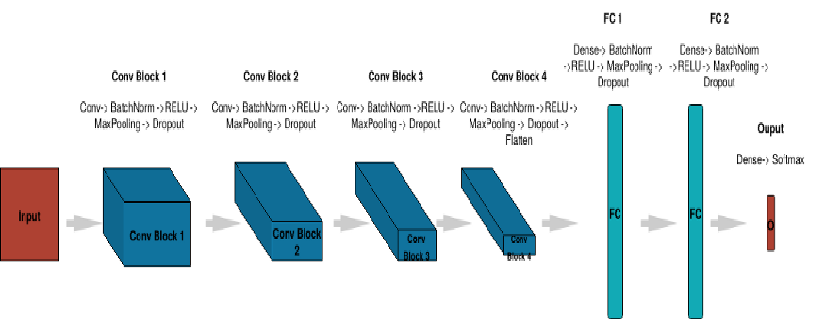

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32,padding="same",strides=(1,1),input_shape=(48,48,1),kernel_size=(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2),padding="same"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(filters=32,padding="same",strides=(1,1),kernel_size=(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2),padding="same"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(filters=64,padding="same",strides=(1,1),kernel_size=(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2),padding="same"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(filters=128,padding="same",strides=(1,1),kernel_size=(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2),padding="same"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dense(7,activation='softmax'))
model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=['accuracy'])
model.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
checkpoint = ModelCheckpoint("./faceModelCustom_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
tboard = TensorBoard(log_dir='./faceModelCustom_log',write_graph=True, write_images=False, write_grads=True)

In [ ]:
his = model.fit(x=X_train,y=y_train,batch_size=64,epochs=75,verbose=2,validation_data = (X_valid,y_valid),callbacks=[checkpoint,early,tboard])

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32,padding="same",strides=(1,1),input_shape=(48,48,1),kernel_size=(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2),padding="same"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dense(7,activation='softmax'))
model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=['accuracy'])
model.summary()

In [ ]:
checkpoint = ModelCheckpoint("./faceModelCustom_2.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
tboard = TensorBoard(log_dir='./faceModelCustom_2_log',write_graph=True, write_images=False, write_grads=True)

In [ ]:
his = model.fit(x=X_train,y=y_train,batch_size=64,epochs=75,verbose=2,validation_data = (X_valid,y_valid),callbacks=[checkpoint,early,tboard])

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=128,padding="same",strides=(1,1),input_shape=(48,48,1),kernel_size=(5,5)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2),padding="same"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(filters=128,padding="same",strides=(1,1),kernel_size=(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2),padding="same"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(filters=64,padding="same",strides=(1,1),kernel_size=(5,5)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2),padding="same"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(filters=128,padding="same",strides=(1,1),kernel_size=(3,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2),padding="same"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dense(7,activation='softmax'))
model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=['accuracy'])
model.summary()

In [ ]:
checkpoint = ModelCheckpoint("./faceModelCustom_3.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
tboard = TensorBoard(log_dir='./faceModelCustom_3_log',write_graph=True, write_images=False, write_grads=True)

In [ ]:
his = model.fit(x=X_train,y=y_train,batch_size=8,epochs=75,verbose=2,validation_data = (X_valid,y_valid),callbacks=[checkpoint,early,tboard])

**ResNet50**

* Implement Skip Connections First
* Know the PreProcessing From Papers
* The images we are training are about 48*48 so be sure of the testing set 
* Make Sure This model can be used for videos 

<b>Identity Block</b>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

**Convoluted Block**

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X


In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape)

    
    
    X = ZeroPadding2D((3, 3))(X_input)
    
    
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

   
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
np.array(X_train).shape

In [ ]:
np.array(y_train).shape

In [ ]:
model = ResNet50(input_shape = (48, 48, 1), classes = 7)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.Adam(0.01),metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau


lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

checkpoint = ModelCheckpoint("./emotionalResNet.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
# tboard = TensorBoard(log_dir='./emotionalResNet_log',write_graph=True, write_images=False, write_grads=True)

callbacks = [
    early,
    checkpoint,
    lr_scheduler,
  
]


In [ ]:
model.fit(x=X_train,y=y_train,batch_size=32,epochs=100,validation_data = (X_valid,y_valid),verbose=2,callbacks = callbacks)

<h2>Trying same model on well balanced data!</h2>

In [ ]:
balanced_model = ResNet50(input_shape = (48, 48, 1), classes = 7)

In [ ]:
balanced_model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.Adam(0.001),metrics=['accuracy'])

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

checkpoint = ModelCheckpoint("./emotionalResNetbalanced.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
# tboard = TensorBoard(log_dir='./emotionalResNet_log',write_graph=True, write_images=False, write_grads=True)

callbacks = [
    early,
    checkpoint,
    lr_scheduler,
  
]

In [ ]:
np.array(X_b_train).shape

In [ ]:
np.array(y_b_train).shape

In [ ]:
balanced_model.fit(x=X_b_train,y=y_b_train,batch_size=8,epochs=100,validation_data = (X_valid,y_valid),verbose=2,callbacks = callbacks)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
mymodel = load_model('../input/myresnet/emotionalResNet.h5')

In [ ]:
X_test.shape

In [ ]:
X_test[0].shape

In [ ]:
y_test[0]

In [ ]:
X_test[0].shape

In [ ]:
mymodel.predict(X_test[0:1])[0]

In [ ]:
y = mymodel.predict(X_test)

In [ ]:
y

In [ ]:
y_pred = np.array([np.argmax(i) for i in y])

In [ ]:
y_pred

In [ ]:
y_test_class = np.array([np.argmax(i) for i in y_test])

In [ ]:
print("Accuracy of resnet50 is",sum(y_pred==y_test_class)/len(y_pred))

Since the training acc is 99 and testing accuracy is around 50, which means our model is suffering from Overfitting,